用户数量： 9988
商品总数量： 2803933
操作记录总数： 11881309
要预测的商品总数量: 310582
要预测的商品总数量: 310582
每种行为的数量
每天的行为数量
结果共有： 1215 条数据
结果共有： 400 条数据
数据个数： 1987933
与要预测商品相关的数据个数 236488


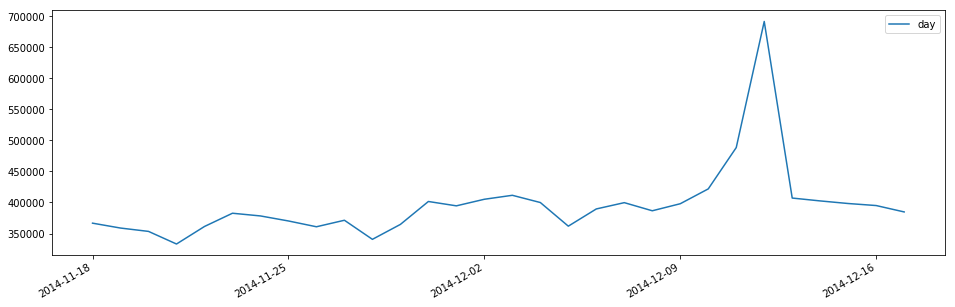

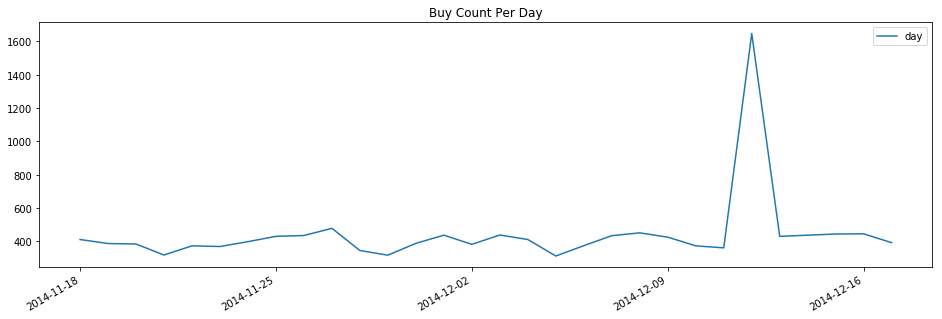

In [1]:
import pandas as pd
import datetime
import matplotlib
from matplotlib import pyplot as plt
import seaborn
import numpy as np

from sklearn.linear_model.logistic import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import Normalizer
from sklearn.metrics import precision_recall_fscore_support,precision_score,recall_score,f1_score
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (16, 5)
filepath="G:/download/Baiduyun/dutir_tianchi_mobile_recommend/"
user_df=pd.read_csv(filepath+'tianchi_mobile_recommend_train_user.csv')
item_df=pd.read_csv(filepath+'tianchi_mobile_recommend_train_item.csv')

user_df.head()
item_df.head()
print('用户数量：',user_df.user_id.unique().shape[0])
print('商品总数量：',user_df.item_id.unique().shape[0])
print('操作记录总数：',len(user_df))
print('要预测的商品总数量:',item_df.item_id.unique().shape[0])

# 只预测这个set中出现的商品
item_id_set=set(item_df.item_id)
print('要预测的商品总数量:',len(item_id_set))

user_df['day']=user_df.time.apply(lambda x:datetime.datetime.strptime(x[:-3], "%Y-%m-%d"))
user_df['hour']=user_df.time.apply(lambda x:int(x[-2:]))

print('每种行为的数量')
pd.DataFrame(user_df.behavior_type.value_counts())

print('每天的行为数量')
pd.DataFrame(user_df.day.value_counts()).plot()

def submit(result_df,filename='../data/submission.csv'):
    result_df=result_df.loc[:,['user_id','item_id']].drop_duplicates()
    print('结果共有：',len(result_df),'条数据')
    result_df.to_csv(filename,index=False)
    
result_df=user_df[(user_df.day=='2014-12-17')&(user_df.behavior_type==3)]
# 筛选出要预测的商品，因为我们只评估这部分商品
result_df=result_df[result_df.item_id.apply(lambda id:id in item_id_set)]
submit(result_df,'../data/submission1.csv')

o2o_user_df=user_df[user_df.item_id.apply(lambda id:id in item_id_set)]
buy_cnt=o2o_user_df[o2o_user_df.behavior_type==4].drop_duplicates(subset=['user_id','item_id','day']).day.value_counts()
pd.DataFrame(buy_cnt).plot()
plt.title('Buy Count Per Day')

result_df=result_df.sort_values('hour',ascending=False).loc[:,['user_id','item_id']].drop_duplicates()
result_df=result_df.iloc[:400]
submit(result_df,'../data/submission2.csv')

user_df=user_df[user_df.day>='2014-12-13']
o2o_user_df=o2o_user_df[o2o_user_df.day>='2014-12-13']
print('数据个数：',len(user_df))
print('与要预测商品相关的数据个数',len(o2o_user_df))

def get_answer_dict(date):
    answer = user_df[(user_df.day==date)&(user_df.behavior_type==4)]
    answer = set(answer.apply(lambda item:'%s-%s'%(item.user_id,item.item_id),axis=1))
    return answer

def label_it(train_xs_df,target_date):
    answer=get_answer_dict(target_date)
    train_xs_df['label']=train_xs_df.apply(lambda item:1 if '%d-%d'%(item.user_id,item.item_id) in answer else 0,axis=1)
    return train_xs_df


In [2]:
%%time

def get_count(counter,value):
    try:
        tmp=counter[value]
    except Exception as e:
        tmp=0
    return tmp
def get_features(target_date,user_df):
    xs=[]
    cnt=0
    #target_date=datetime.datetime(2014,12,17)
    deltaday=2
    start_date=target_date-datetime.timedelta(deltaday)
    tmp_df=user_df[(user_df.day>=start_date)&(user_df.day<target_date)]
    weight={1:1,2:5,3:10,4:-5}
    for user_id,items in tmp_df.groupby(by=['user_id']):
        #用户总点击次数
        counters=items.behavior_type.value_counts()
        user_click=get_count(counters,1)
        user_buy=get_count(counters,4)
        for item_id,goods in items.groupby(by=['item_id']):
            x=[user_id,item_id]
            goodcounters=goods.behavior_type.value_counts()
            goods_user_count=get_count(goodcounters,1)
            #统计操作信息
            vals=np.zeros([deltaday,3,4])
#             attention=0 #用户对商品的注意力
            for info in goods.itertuples():
                day=(target_date-info.day).days-1
                hour=int(info.hour/8)
                behavior=info.behavior_type-1
                vals[day][hour][behavior]+=1
#                 attention+=weight[info.behavior_type]
            x.extend(list(vals.reshape((deltaday*12))))
            x.append(goods_user_count)#用户对商品的点击次数
            x.append(user_click)#用户的点击次数
            x.append(goods_user_count/(1.0+user_click))#用户对商品的兴趣
#             x.append(attention)#用户对商品的注意力
            #
            xs.append(x)
            cnt=cnt+1
            if cnt%10000==0:
                print(datetime.datetime.now(),'processed %d'%(cnt,))
    headers=['user_id','item_id']
    for i in range(deltaday):
        for j in range(3):
            for k in range(4):
                headers.append('d%d_h%d_b%d'%(i+1,j+1,k+1))
#     headers.extend(['guc','uc','interest','attention'])
    headers.extend(['guc','uc','interest'])
    xs_df=pd.DataFrame(xs,columns=headers)
#     xs_df=pd.DataFrame(xs)
    return xs_df

# valid_xs_df=get_features(datetime.datetime(2014,12,17),o2o_user_df)

Wall time: 0 ns


In [3]:
%%time
train_xs_df=get_features(datetime.datetime(2014,12,16),user_df)
print(datetime.datetime.now(),'train_xs_df processed')
# 验证集和测试集只使用o2o的商品就可以了
valid_xs_df=get_features(datetime.datetime(2014,12,17),o2o_user_df)
print(datetime.datetime.now(),'valid_xs_df processed')
test_xs_df=get_features(datetime.datetime(2014,12,18),o2o_user_df)
print(datetime.datetime.now(),'test_xs_df processed')

label_it(train_xs_df,datetime.datetime(2014,12,16))
label_it(valid_xs_df,datetime.datetime(2014,12,17))

positive_num=np.sum(train_xs_df.label)
negative_num=len(train_xs_df)-positive_num
print('正样本个数',positive_num,'负样本个数',negative_num,'负正样本比例',negative_num/positive_num)


2019-01-07 21:26:59.738609 processed 10000
2019-01-07 21:27:21.128206 processed 20000
2019-01-07 21:27:43.622397 processed 30000
2019-01-07 21:28:05.439603 processed 40000
2019-01-07 21:28:26.533319 processed 50000
2019-01-07 21:28:47.752493 processed 60000
2019-01-07 21:29:09.524799 processed 70000
2019-01-07 21:29:31.518104 processed 80000
2019-01-07 21:29:57.815596 processed 90000
2019-01-07 21:30:23.323024 processed 100000
2019-01-07 21:30:47.831720 processed 110000
2019-01-07 21:31:13.197667 processed 120000
2019-01-07 21:31:38.449200 processed 130000
2019-01-07 21:32:03.774715 processed 140000
2019-01-07 21:32:29.001195 processed 150000
2019-01-07 21:32:54.210817 processed 160000
2019-01-07 21:33:19.931143 processed 170000
2019-01-07 21:33:45.302150 processed 180000
2019-01-07 21:34:10.707297 processed 190000
2019-01-07 21:34:36.082765 processed 200000
2019-01-07 21:35:01.873903 processed 210000
2019-01-07 21:35:27.633181 processed 220000
2019-01-07 21:35:53.630733 processed 2300

In [4]:
# from xgboost.sklearn import XGBClassifier
# sample_xs_df=train_xs_df
# from imblearn.combine import SMOTEENN
# scaler=Normalizer(norm='l1')
# scaler.fit(sample_xs_df.drop(['user_id','item_id','label'],axis=1))
# train_xs=scaler.transform(sample_xs_df.drop(['user_id','item_id','label'],axis=1))
# valid_xs=scaler.transform(valid_xs_df.drop(['user_id','item_id','label'],axis=1))
# test_xs=scaler.transform(test_xs_df.drop(['user_id','item_id'],axis=1))
# sm = SMOTEENN()
# X_resampled,y_resampled=sm.fit_sample(train_xs,sample_xs_df.label)

In [5]:
answer_cnt=len(o2o_user_df[(o2o_user_df.day=='2014-12-17')&(o2o_user_df.behavior_type==4)])
def evaluate(ytrue,ypred,answer_cnt,rate):
    ypred=ypred>rate
    right_cnt=np.sum(ytrue&ypred)
    predict_cnt=np.sum(ypred)
    precision=right_cnt/predict_cnt
    recall=right_cnt/answer_cnt
    f1=0
    if precision>0 or recall>0:
        f1=2*precision*recall/(precision+recall)
    print('预测数量',predict_cnt,'答案数量',answer_cnt)
    print('正确个数',right_cnt)
    print('precision',precision)
    print('recall',recall)
    print('f1',f1)
    return precision,recall,f1

In [6]:
# from xgboost.sklearn import XGBClassifier
# xgbc=XGBClassifier(
#                      scale_pos_weight=0.3,
#                      learning_rate=0.05,
#                      min_child_weight=1,# 叶子节点最小权重
#                      max_depth=5,# 树的深度
#                      n_estimatores=256,#树的个数--1000棵树建立xgboost
#                      subsample=0.8,
#                      colsample_bytree=0.8,
#                      objective='binary:logistic',
#                      gamma = 0,#
#                      seed=27)
# xgbc.fit(X_resampled,
#          y_resampled,
#          eval_set=[(valid_xs,valid_xs_df.label)],
#          early_stopping_rounds=50,
#          eval_metric = "auc"
#         ) 
# valid_yp=xgbc.predict_proba(valid_xs)[:,1]
# test_yp=xgbc.predict_proba(test_xs)[:,1]
# rate=0.6
# evaluate(valid_xs_df.label,valid_yp,answer_cnt,rate)
# test_xs_df['yp']=test_yp
# submit(test_xs_df[test_xs_df.yp>rate],filename='../data/old_smoteenn_xgbc.csv')
# test_xs_df=test_xs_df.drop(['yp'],axis=1)



In [7]:
# valid_yp=xgbc.predict_proba(valid_xs)[:,1]
# test_yp=xgbc.predict_proba(test_xs)[:,1]
# rate=0.9
# evaluate(valid_xs_df.label,valid_yp,answer_cnt,rate)
# test_xs_df['yp']=test_yp
# submit(test_xs_df[test_xs_df.yp>rate],filename='../data/old_test_smoteenn_xgbc.csv')
# test_xs_df=test_xs_df.drop(['yp'],axis=1)

In [8]:
# def cut_value(test_xs_df,test_yp,name):
#     test_xs_df['yp']=test_yp
#     a=test_xs_df[test_xs_df.yp>0.9]
#     length=a.shape[0]
#     if length > 450:
#         submit(a,filename='../data/'+name+'_cut.csv')
#     else:    
#         b=test_xs_df[(test_xs_df.yp>0.5)&(test_xs_df.yp<0.7)]
#         f=(450-length)/b.shape[0]
#         b=b.sample(frac=f)
#         c=pd.concat([a,b])
#         submit(c,filename='../data/'+name+'_cut.csv')
# print("cut test")
# valid_yp=xgbc.predict_proba(valid_xs)[:,1]
# test_yp=xgbc.predict_proba(test_xs)[:,1]
# cut_xs_df=test_xs_df.copy()
# cut_value(cut_xs_df,test_yp,"oldtest")
# print(test_xs.shape)
# test_xs.drop(['yp'],axis=1)

In [9]:
#对正样本进行过采样
positive_xs_df=train_xs_df[train_xs_df.label==1]

positive_xs_df=positive_xs_df.sample(n=40000,replace=True)

sample_xs_df=pd.concat([train_xs_df,positive_xs_df])

sample_xs_df=sample_xs_df.sample(frac=1.0)

In [10]:
scaler=Normalizer(norm='l1')
scaler.fit(sample_xs_df.drop(['user_id','item_id','label'],axis=1))
train_xs=scaler.transform(sample_xs_df.drop(['user_id','item_id','label'],axis=1))
valid_xs=scaler.transform(valid_xs_df.drop(['user_id','item_id','label'],axis=1))
test_xs=scaler.transform(test_xs_df.drop(['user_id','item_id'],axis=1))

In [16]:
#梯度提升决策树
clf=GradientBoostingClassifier(n_estimators=200,learning_rate=0.08,max_depth=5)
clf.fit(train_xs,sample_xs_df.label)
# 这里可以用predict也可以用predict_proba
# predict只输出0和1，
# predict_proba 可以输出概率值
valid_yp=clf.predict_proba(valid_xs)[:,1]
test_yp=clf.predict_proba(test_xs)[:,1]
evaluate(valid_xs_df.label,valid_yp,answer_cnt,0.5)
test_xs_df['yp']=test_yp
submit(test_xs_df[test_xs_df.yp>0.74],filename='../data/fea_submission_gbdt.csv')
test_xs_df=test_xs_df.drop(['yp'],axis=1)

预测数量 606 答案数量 432
正确个数 25
precision 0.041254125412541254
recall 0.05787037037037037
f1 0.048169556840077066
结果共有： 193 条数据


In [12]:
valid_yp=clf.predict_proba(valid_xs)[:,1]
test_yp=clf.predict_proba(test_xs)[:,1]
rate=0.8
evaluate(valid_xs_df.label,valid_yp,answer_cnt,0.5)
test_xs_df['yp']=test_yp
submit(test_xs_df[test_xs_df.yp>rate],filename='../data/1fea_submission_gbdt.csv')

预测数量 845 答案数量 432
正确个数 36
precision 0.04260355029585799
recall 0.08333333333333333
f1 0.056382145653876274
结果共有： 145 条数据


In [13]:
# from xgboost.sklearn import XGBClassifier
# # from sklearn.grid_search import GridSearchCV 
# xgbc=XGBClassifier(
#                     scale_pos_weight=1,
#                      learning_rate=0.09,
#                      min_child_weight=1,# 叶子节点最小权重
#                      max_depth=9,# 树的深度
#                      n_estimatores=140,#树的个数--1000棵树建立xgboost
#                      subsample=0.8,
#                      colsample_bytree=0.8,
#                      objective='binary:logistic',
#                      gamma = 0.3,
#                      seed=27)
# xgbc.fit(train_xs,
#          sample_xs_df.label,
#          eval_set=[(valid_xs,valid_xs_df.label)],
#          early_stopping_rounds=50,
#          eval_metric = "auc"
#         ) 
# valid_yp=xgbc.predict_proba(valid_xs)[:,1]
# test_yp=xgbc.predict_proba(test_xs)[:,1]
# evaluate(valid_xs_df.label,valid_yp,answer_cnt)
# test_xs_df['yp']=test_yp
# submit(test_xs_df[test_xs_df.yp>0.5],filename='../data/xgbc.csv')
# test_xs_df=test_xs_df.drop(['yp'],axis=1)

In [14]:
# def evaluate(ytrue,ypred,answer_cnt):
#     ypred=ypred>0.5
#     right_cnt=np.sum(ytrue&ypred)
#     predict_cnt=np.sum(ypred)
#     precision=right_cnt/predict_cnt
#     recall=right_cnt/answer_cnt
#     f1=0
#     if precision>0 or recall>0:
#         f1=2*precision*recall/(precision+recall)
#     print('预测数量',predict_cnt,'答案数量',answer_cnt)
#     print('正确个数',right_cnt)
#     print('precision',precision)
#     print('recall',recall)
#     print('f1',f1)
#     return precision,recall,f1
# valid_yp=xgbc.predict_proba(valid_xs)[:,1]
# test_yp=xgbc.predict_proba(test_xs)[:,1]
# evaluate(valid_xs_df.label,valid_yp,answer_cnt)
# test_xs_df['yp']=test_yp
# submit(test_xs_df[test_xs_df.yp>0.5],filename='../data/xgbc.csv')
# test_xs_df=test_xs_df.drop(['yp'],axis=1)

In [15]:
# #随机森林模型
# clf=RandomForestClassifier(n_estimators=200)
# clf.fit(train_xs,sample_xs_df.label)
# # 这里可以用predict也可以用predict_proba
# # predict只输出0和1，
# # predict_proba 可以输出概率值
# valid_yp=clf.predict_proba(valid_xs)[:,1]
# test_yp=clf.predict_proba(test_xs)[:,1]
# evaluate(valid_xs_df.label,valid_yp,answer_cnt)
# test_xs_df['yp']=test_yp
# submit(test_xs_df[test_xs_df.yp>0.5],filename='../data/fea_submission_rf.csv')